# Imports

In [1]:
# HIDE
%load_ext autoreload
%autoreload 2

In [2]:
import sys 
sys.path.append('../')
sys.path.append('../../')

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import time

import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as t_optim
#import skorch
import pickle
from IPython import display
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
#from cont_metrics.density_estimation.pytorch_kde import kde
#from cont_metrics.hgr import hgr_cond
#from cont_metrics.hgr import hgr
import aif360 as aif

from fairness.helpers import load_ICU_data
from fairness.helpers import plot_distributions
from fairness.helpers import *

#from fairlearn.postprocessing import ThresholdOptimizer
#from fairlearn.postprocessing import plot_threshold_optimizer

from fairness.avd_helpers import *

#from aif360.algorithms.postprocessing import *
import aif360
from aif360.datasets import CompasDataset
from aif360.algorithms.inprocessing import AdversarialDebiasing
#from comet_ml import Experiment
import tensorflow.compat.v1 as tf
from aif360.datasets import BinaryLabelDataset
from aif360.algorithms.preprocessing import LFR

torch.manual_seed(1)
np.random.seed(7)
sns.set(style="white", palette="colorblind", color_codes=True, context="talk")
sns.set_theme()

tf.disable_eager_execution()

%matplotlib inline

pip install 'aif360[LawSchoolGPA]'
2023-02-03 18:10:06.341677: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'


# Load Data

In [4]:
df = pd.read_csv('../data/other/bank-additional-full.csv', sep=';').sample(12000, random_state=111)

In [5]:
dff = pd.get_dummies(df.drop(columns=['y']), drop_first=True)
dff = dff.assign(age_cat = ((dff.age<=33) | (dff.age>=60)).astype(int))

In [6]:
X = dff.drop(columns=['age', 'age_cat'])
y = (df.y=='yes').astype(int)
Z = dff[['age_cat']]

In [7]:
(X_train, X_test, y_train, y_test, Z_train, Z_test) = split_scale_pipe(X, y, Z, stratify=y)

In [8]:
X_train.head()

,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,job_blue-collar,...,month_may,month_nov,month_oct,month_sep,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_nonexistent,poutcome_success
18378,-0.738223,-0.205224,0.190913,-0.343545,0.845600,0.594808,-0.481061,0.781097,0.848728,-0.527731,...,-0.714545,-0.338862,-0.136025,-0.119876,-0.513508,1.915531,-0.487729,-0.48406,0.392232,-0.180838
36210,-0.415688,0.498602,0.190913,-0.343545,-1.192886,-1.188702,-1.239748,-1.348170,-0.920393,-0.527731,...,1.399493,-0.338862,-0.136025,-0.119876,-0.513508,1.915531,-0.487729,-0.48406,0.392232,-0.180838
26568,0.761762,0.850515,0.190913,-0.343545,-0.109940,-0.654519,-0.329324,0.267494,0.405762,-0.527731,...,-0.714545,2.951057,-0.136025,-0.119876,-0.513508,1.915531,-0.487729,-0.48406,0.392232,-0.180838
21564,-0.505065,-0.205224,0.190913,-0.343545,0.845600,-0.229956,0.949604,0.778218,0.848728,-0.527731,...,-0.714545,-0.338862,-0.136025,-0.119876,-0.513508,-0.522048,2.050321,-0.48406,0.392232,-0.180838
37986,0.979376,-0.557137,0.190913,-0.343545,-2.212130,-2.083067,2.315240,-1.620518,-2.039465,-0.527731,...,-0.714545,-0.338862,-0.136025,8.341956,1.947391,-0.522048,-0.487729,-0.48406,0.392232,-0.180838


### Train Biased Classifier

In [9]:
train_data = BinaryLabelDataset(df=X_train.assign(y = y_train, age_cat=Z_train), label_names=['y'], protected_attribute_names=['age_cat'])
test_data = BinaryLabelDataset(df=X_test.assign(y=y_test, age_cat=Z_test), label_names=['y'], protected_attribute_names=['age_cat'])


tf.reset_default_graph()
sess = tf.Session()


privileged_groups = [{'age_cat': 1}]
unprivileged_groups = [{'age_cat': 0}]

biased_model = AdversarialDebiasing(unprivileged_groups=unprivileged_groups,
                 privileged_groups=privileged_groups,
                 scope_name='classifier',
                 debias=False,
                 sess=sess,
                 seed=111).fit(train_data)

dataset_nodebiasing_test = biased_model.predict(test_data)
acc = metrics.accuracy_score(y_test, dataset_nodebiasing_test.labels)
b_acc = metrics.balanced_accuracy_score(y_test, dataset_nodebiasing_test.labels)
prule = p_rule(dataset_nodebiasing_test.scores, Z_test)

2023-02-03 18:10:19.659953: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
2023-02-03 18:10:19.809756: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:357] MLIR V1 optimization pass is not enabled


epoch 0; iter: 0; batch classifier loss: 0.718902
epoch 1; iter: 0; batch classifier loss: 0.295277
epoch 2; iter: 0; batch classifier loss: 0.201587
epoch 3; iter: 0; batch classifier loss: 0.228513
epoch 4; iter: 0; batch classifier loss: 0.136117
epoch 5; iter: 0; batch classifier loss: 0.129870
epoch 6; iter: 0; batch classifier loss: 0.178771
epoch 7; iter: 0; batch classifier loss: 0.145991
epoch 8; iter: 0; batch classifier loss: 0.184081
epoch 9; iter: 0; batch classifier loss: 0.192601
epoch 10; iter: 0; batch classifier loss: 0.161705
epoch 11; iter: 0; batch classifier loss: 0.144559
epoch 12; iter: 0; batch classifier loss: 0.158092
epoch 13; iter: 0; batch classifier loss: 0.140872
epoch 14; iter: 0; batch classifier loss: 0.142355
epoch 15; iter: 0; batch classifier loss: 0.168629
epoch 16; iter: 0; batch classifier loss: 0.098874
epoch 17; iter: 0; batch classifier loss: 0.124167
epoch 18; iter: 0; batch classifier loss: 0.236400
epoch 19; iter: 0; batch classifier loss:

In [10]:
print(f'accuracy = {acc * 100:.2f}%')
print(f'balanced accuracy = {b_acc * 100:.2f}%')
print(f'p-rule = {prule:.2f}%')

accuracy = 90.58%
balanced accuracy = 73.38%
p-rule = 44.04%


In [11]:
dataset_nodebiasing_test = biased_model.predict(test_data)
test_results = pd.DataFrame(Z_test).assign(biased_pred = dataset_nodebiasing_test.labels)
test_results.head()

,age_cat,biased_pred
26792,1,0.0
26127,1,0.0
30552,0,0.0
14952,1,0.0
27817,1,1.0


In [12]:
test_results.assign(n = 1).groupby(['age_cat', 'biased_pred']).count()

n
age_cat biased_pred      
0       0.0          3665
        1.0           264
1       0.0          1755
        1.0           316

### LFR

In [13]:
from aif360.sklearn.preprocessing import LearnedFairRepresentations as LFRsk

pip install 'aif360[FairAdapt]'


In [14]:
lfr_accs = []
lfr_b_accs = []
lfr_prules = []
lfr_numch = []
lfr_changed = []

In [18]:
for i in range(10):

    lfrsk = LFRsk(prot_attr='age_cat', reconstruct_weight=0.01,
                     target_weight=1., fairness_weight=14., random_state=11).fit(X_train.assign(age_cat=Z_train).set_index('age_cat'), y_train)

    X_train_transf = lfrsk.transform(X_train.assign(age_cat=Z_train).set_index('age_cat')).set_index(X_train.index)
    X_test_transf = lfrsk.transform(X_test.assign(age_cat=Z_test).set_index('age_cat')).set_index(X_test.index)

    train_data = PandasDataSet(X_train_transf, y_train, Z_train)
    test_data = PandasDataSet(X_test_transf, y_test, Z_test)

    train_loader = DataLoader(train_data, batch_size=32, shuffle=True, drop_last=False)

    start = time.time()

    train_loader = DataLoader(train_data, batch_size=32, shuffle=True, drop_last=False)

    clf = Classifier_old(n_features=X_train.shape[1])
    clf_criterion = nn.BCELoss()
    clf_optimizer = optim.Adam(clf.parameters())

    N_CLF_EPOCHS = 30

    # pretrain classifier

    clf, losses = fit_clf(clf, clf_optimizer, clf_criterion, train_loader, num_epochs=N_CLF_EPOCHS)

    with torch.no_grad():
        pre_clf_test = clf(test_data.tensors[0])

    y_pre_clf = pd.Series(pre_clf_test.data.numpy().ravel(),
                         index=y_test.index)

    acc = metrics.accuracy_score(y_test, y_pre_clf > 0.5) * 100
    b_acc = metrics.balanced_accuracy_score(y_test, y_pre_clf > 0.5) * 100
    prule = p_rule(y_pre_clf, Z_test.age_cat)
    
    print(f'run {i}')
    print(f'accuracy = {acc:.2f}%')
    print(f'balanced accuracy = {b_acc:.2f}%')
    print(f'p-rule = {prule:2f}%')

    lfr_accs.append(acc)
    lfr_b_accs.append(b_acc)
    lfr_prules.append(prule)

    t = test_results.assign(lfr_pred = (y_pre_clf>0.5)*1)
    t = t.assign(lfr_change = t.lfr_pred - t.biased_pred)
    changed = t[t.lfr_change!=0]

    num_changed = len(changed)
    lfr_changed.append(changed)
    lfr_numch.append(num_changed)
    
    print(f'num changed = {num_changed}')
    print()

accuracy = 90.40%
balanced accuracy = 70.74%
p-rule = 83.325364%
num changed = 393
accuracy = 90.50%
balanced accuracy = 70.79%
p-rule = 83.099896%
num changed = 391
accuracy = 90.48%
balanced accuracy = 70.53%
p-rule = 83.299156%
num changed = 392
accuracy = 90.40%
balanced accuracy = 71.75%
p-rule = 79.798012%
num changed = 389
accuracy = 90.58%
balanced accuracy = 70.46%
p-rule = 83.388748%
num changed = 388
accuracy = 90.57%
balanced accuracy = 70.20%
p-rule = 85.081805%
num changed = 389
accuracy = 90.43%
balanced accuracy = 70.69%
p-rule = 83.637759%
num changed = 395
accuracy = 90.50%
balanced accuracy = 70.54%
p-rule = 84.447370%
num changed = 395
accuracy = 90.42%
balanced accuracy = 71.13%
p-rule = 82.166544%
num changed = 388
accuracy = 90.48%
balanced accuracy = 70.53%
p-rule = 84.007540%
num changed = 396


In [23]:
lfr_stats = pd.DataFrame({
    'Run': range(len(lfr_accs)),
    'Accuracy':lfr_accs,
    'Balanced Accuracy': lfr_b_accs,
    'P%-rule': lfr_prules,
    '% of predictions changed': [l/len(X_test)*100 for l in lfr_numch],
    'num of predictions changed': lfr_numch
})

In [15]:
#dataset_nodebiasing_test = model.predict(test_tr)
test_results = test_results.assign(
    lfr_pred = (y_pre_clf>0.5).astype(int)
)

In [16]:
test_results = test_results.assign(lfr_change = test_results.lfr_pred - test_results.biased_pred)

In [17]:
metrics.balanced_accuracy_score(y_test, test_results.lfr_pred)
p_rule(y_pre_clf, Z_test.age_cat)

84.39160381750158

In [18]:
dataset_nodebiasing_test.labels.flatten()

array([0., 0., 0., ..., 0., 0., 0.])

### Adversarial Debiasing

In [19]:
import tensorflow.compat.v1 
from aif360.datasets import BinaryLabelDataset

tf.disable_eager_execution()

In [27]:
adv_accs = []
adv_b_accs = []
adv_prules = []
adv_numch = []
adv_changed = []

In [30]:
for i in range(10):
    privileged_groups = [{'age_cat': 1}]
    unprivileged_groups = [{'age_cat': 0}]

    train_bdf = BinaryLabelDataset(df=X_train.join(y_train).join(Z_train), label_names=['y'], protected_attribute_names=['age_cat'])
    test_bdf = BinaryLabelDataset(df=X_test.join(y_test).join(Z_test), label_names=['y'], protected_attribute_names=['age_cat'])

    tf.reset_default_graph()
    sess = tf.Session()

    debiased_model = AdversarialDebiasing(privileged_groups = privileged_groups,
                              unprivileged_groups = unprivileged_groups,
                              scope_name='debiased_classifier',
                              debias=True,
                              sess=sess,
                              adversary_loss_weight=4
                            )

    debiased_model.fit(train_bdf)

    from aif360.metrics import BinaryLabelDatasetMetric

    dataset_debiasing_test = debiased_model.predict(test_bdf)
    preds = dataset_debiasing_test.labels
    acc = metrics.accuracy_score(y_test, preds)
    b_acc = metrics.balanced_accuracy_score(y_test, preds)
    prule = p_rule(preds, Z_test)

    metric_dataset_debiasing_test = BinaryLabelDatasetMetric(dataset_debiasing_test, 
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)

    adv_accs.append(acc)
    adv_b_accs.append(b_acc)
    adv_prules.append(prule)

    t = test_results.assign(pred = preds)
    t = t.assign(change = t.pred - t.biased_pred)
    changed = t[t.change!=0]

    num_changed = len(changed)
    adv_numch.append(num_changed)
    adv_changed.append(changed)
    print(f'run {i}')
    print(num_changed)

    print("Test set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_dataset_debiasing_test.mean_difference())

    print(f'accuracy = {metrics.accuracy_score(y_test, dataset_debiasing_test.labels) * 100}%')
    print(f'p-rule = {p_rule(dataset_debiasing_test.labels, Z_test)}%')
    print()

epoch 0; iter: 0; batch classifier loss: 0.714405; batch adversarial loss: 0.731515
epoch 1; iter: 0; batch classifier loss: 0.682179; batch adversarial loss: 0.751836
epoch 2; iter: 0; batch classifier loss: 0.654584; batch adversarial loss: 0.729366
epoch 3; iter: 0; batch classifier loss: 0.607445; batch adversarial loss: 0.711277
epoch 4; iter: 0; batch classifier loss: 0.478952; batch adversarial loss: 0.678263
epoch 5; iter: 0; batch classifier loss: 0.369650; batch adversarial loss: 0.687320
epoch 6; iter: 0; batch classifier loss: 0.290418; batch adversarial loss: 0.661154
epoch 7; iter: 0; batch classifier loss: 0.308526; batch adversarial loss: 0.670212
epoch 8; iter: 0; batch classifier loss: 0.392938; batch adversarial loss: 0.651660
epoch 9; iter: 0; batch classifier loss: 0.308784; batch adversarial loss: 0.634964
epoch 10; iter: 0; batch classifier loss: 0.250660; batch adversarial loss: 0.669227
epoch 11; iter: 0; batch classifier loss: 0.190296; batch adversarial loss:

In [26]:
len(adv_accs)

11

In [31]:
adv_stats = pd.DataFrame({
    'Run': range(len(adv_accs)),
    'Accuracy':adv_accs,
    'Balanced Accuracy': adv_b_accs,
    'P%-rule': adv_prules,
    'Number of instances changed': adv_numch,
    '% of predictions changed': [l/len(X_test)*100 for l in adv_numch]
})

adv_stats

,Run,Accuracy,Balanced Accuracy,P%-rule,Number of instances changed,% of predictions changed
0,0,0.902833,0.692721,81.616434,264,4.400000
1,1,0.902667,0.689448,84.988461,243,4.050000
2,2,0.902500,0.695077,88.239314,244,4.066667
3,3,0.902167,0.691073,87.831071,270,4.500000
4,4,0.906667,0.707602,96.890029,263,4.383333
5,5,0.900667,0.692134,94.857557,273,4.550000
6,6,0.902333,0.698162,83.895427,221,3.683333
7,7,0.908500,0.718811,76.417779,196,3.266667
8,8,0.904167,0.676306,92.460434,282,4.700000
9,9,0.906167,0.699690,74.990357,202,3.366667


In [22]:
print(f'accuracy = {metrics.accuracy_score(y_test, dataset_debiasing_test.labels) * 100:.2f}%')
print(f'balanced accuracy = {metrics.balanced_accuracy_score(y_test, dataset_debiasing_test.labels) * 100:.2f}%')
print(f'p-rule = {p_rule(dataset_debiasing_test.labels, Z_test):.2f}%')

accuracy = 90.53%
balanced accuracy = 68.21%
p-rule = 85.12%


In [23]:
dataset_debiasing_test = debiased_model.predict(test_bdf)
test_results = test_results.assign(adv_pred = dataset_debiasing_test.labels)

In [24]:
test_results.head()

,age_cat,biased_pred,lfr_pred,lfr_change,adv_pred
26792,1,0.0,0,0.0,0.0
26127,1,0.0,0,0.0,0.0
30552,0,0.0,0,0.0,0.0
14952,1,0.0,0,0.0,0.0
27817,1,1.0,0,-1.0,0.0


### Adversarial Learning (Equalized Odds)

In [44]:
from fairlearn_int.adversarial import AdversarialFairnessClassifier as AFC
from fairlearn_int.metrics import equalized_odds_difference, equalized_odds_ratio
import fairness.avd_helpers as avh


In [48]:
adv_eo_accs = []
adv_eo_b_accs = []
adv_eo_prules = []
adv_eo_eqd = []
adv_eo_eqr = []
adv_eo_numch = []
adv_eo_changed = []

In [49]:
for i in range(10):
    torch.manual_seed(i*100000)
    afc = AFC(backend='torch',
       predictor_model=[200, nn.ReLU()],
       adversary_model=avh.Adversary_old(n_input=2, n_hidden=128),
       constraints='equalized_odds',
       epochs=30,
       alpha=2.43,
       random_state=i*100000,
       shuffle=True).fit(X_train, y_train, sensitive_features=Z_train)

    preds = afc.predict(X_test)

    preds.index=X_test.index
    acc = metrics.accuracy_score(y_test, preds) * 100
    b_acc = metrics.balanced_accuracy_score(y_test, preds) * 100
    prule = p_rule(preds.values, Z_test.values.flatten())
    eq_odds_ratio = equalized_odds_ratio(y_true=y_test, y_pred=preds, 
                                                         sensitive_features=Z_test)
    eq_odds_diff = equalized_odds_difference(y_true=y_test, y_pred=preds, 
                                                         sensitive_features=Z_test)


    adv_eo_accs.append(acc)
    adv_eo_b_accs.append(b_acc)
    adv_eo_prules.append(prule)
    adv_eo_eqd.append(eq_odds_diff)
    adv_eo_eqr.append(eq_odds_ratio)

    t = test_results.assign(pred = preds)
    t = t.assign(change = t.pred - t.biased_pred)
    changed = t[t.change!=0]

    num_changed = len(changed)
    adv_eo_numch.append(num_changed)
    adv_eo_changed.append(changed)

    print(f'run {i}')
    print(f'accuracy = {acc:.2f}%')
    print(f'balanced accuracy = {b_acc:.2f}%')
    print(f'p-rule = {prule:.2f}%')
    print(f'Equalized Odds ratio = {eq_odds_ratio:.2f}')
    print(f'Equalized Odds difference = {eq_odds_diff:.2f}')
    print(f'Number of predictions changed = {num_changed/len(test_results)*100:.2f}')
    print()

run 0
accuracy = 90.25%
balanced accuracy = 72.37%
p-rule = 51.62%
Equalized Odds ratio = 0.47
Equalized Odds difference = 0.04
Number of predictions changed = 0.06866666666666667

run 1
accuracy = 90.05%
balanced accuracy = 62.08%
p-rule = 58.57%
Equalized Odds ratio = 0.59
Equalized Odds difference = 0.02
Number of predictions changed = 0.075

run 2
accuracy = 89.83%
balanced accuracy = 73.34%
p-rule = 45.75%
Equalized Odds ratio = 0.41
Equalized Odds difference = 0.07
Number of predictions changed = 0.07116666666666667

run 3
accuracy = 90.50%
balanced accuracy = 69.27%
p-rule = 50.23%
Equalized Odds ratio = 0.54
Equalized Odds difference = 0.06
Number of predictions changed = 0.06916666666666667

run 4
accuracy = 90.98%
balanced accuracy = 73.36%
p-rule = 55.07%
Equalized Odds ratio = 0.54
Equalized Odds difference = 0.03
Number of predictions changed = 0.05633333333333333

run 5
accuracy = 90.45%
balanced accuracy = 73.24%
p-rule = 45.97%
Equalized Odds ratio = 0.38
Equalized Odds

In [50]:
adv_eo_stats = pd.DataFrame({
    'Run': range(1,11),
    'Accuracy':adv_eo_accs,
    'Balanced Accuracy': adv_eo_b_accs,
    'P%-rule': adv_eo_prules,
    'Number of instances changed': adv_eo_numch,
    '% of predictions changed': [l/len(X_test)*100 for l in adv_eo_numch]
})

In [51]:
adv_eo_stats

,Run,Accuracy,Balanced Accuracy,P%-rule,Number of instances changed,% of predictions changed
0,1,90.250000,72.369001,51.620049,412,6.866667
1,2,90.050000,62.082455,58.567348,450,7.500000
2,3,89.833333,73.341940,45.754667,427,7.116667
3,4,90.500000,69.267258,50.232764,415,6.916667
4,5,90.983333,73.355192,55.070790,338,5.633333
5,6,90.450000,73.244914,45.974433,362,6.033333
6,7,88.750000,73.811414,55.053307,506,8.433333
7,8,89.616667,68.959425,51.101129,484,8.066667
8,9,91.083333,71.885588,52.285528,318,5.300000
9,10,90.616667,66.026670,45.342463,382,6.366667


In [30]:
test_results = test_results.assign(adv_eq_pred = pp)
test_results = test_results.assign(adv_eq_change = test_results.adv_eq_pred - test_results.biased_pred)

In [31]:
test_results.head()

,age_cat,biased_pred,lfr_pred,lfr_change,adv_pred,adv_eq_pred,adv_eq_change
26792,1,0.0,0,0.0,0.0,0,0.0
26127,1,0.0,0,0.0,0.0,0,0.0
30552,0,0.0,0,0.0,0.0,0,0.0
14952,1,0.0,0,0.0,0.0,0,0.0
27817,1,1.0,0,-1.0,0.0,1,0.0


### Equal Odds (optimizing equalized odds)

In [52]:
bld_train = BinaryLabelDataset(df=X_train.join(y_train).join(Z_train), label_names=['y'], protected_attribute_names=['age_cat'])

In [53]:
biased_preds = biased_model.predict(bld_train).labels#.label_names#.convert_to_dataframe()[0]

In [54]:
from fairlearn_int.postprocessing import ThresholdOptimizer as TO

In [62]:
eo_accs = []
eo_b_accs = []
eo_prules = []
eo_rs = []
eo_ds = []
eo_numch = []
eo_changed = []

In [63]:
for i in range(10):

    m = TO(estimator=biased_model, predict_method='predict',
           prefit=True, constraints='equalized_odds',
          objective='accuracy_score')
    
    m = m.fit(X=X_train.assign(age_cat=Z_train).set_index('age_cat'), 
                                                                 y=y_train,
                                                                 Z=Z_train, 
                                                                 sensitive_features=Z_train,
                                                                             bld=bld_train)

    preds = m.predict(X=X_test, y=y_test, Z=Z_test, sensitive_features=Z_test,
                      bld=BinaryLabelDataset(df=X_test.join(y_test).join(Z_test), label_names=['y'], protected_attribute_names=['age_cat'])
                     )

    acc = metrics.accuracy_score(y_test, preds) * 100
    b_acc = metrics.balanced_accuracy_score(y_test, preds) * 100
    prule = p_rule(preds, Z_test.values.flatten())
    eq_odds_ratio = equalized_odds_ratio(y_true=y_test, y_pred=preds, 
                                                         sensitive_features=Z_test)
    eq_odds_diff = equalized_odds_difference(y_true=y_test, y_pred=preds, 
                                                         sensitive_features=Z_test)

    t = test_results.assign(pred = preds)
    t = t.assign(change = t.pred - t.biased_pred)
    changed = t[t.change!=0]

    num_changed = len(changed)
    eo_numch.append(num_changed)
    eo_changed.append(changed)
    eo_accs.append(acc)
    eo_b_accs.append(b_acc)
    eo_prules.append(prule)
    eo_rs.append(eq_odds_ratio)
    eo_ds.append(eq_odds_diff)

    print(f'run {i}:')
    print(f'accuracy = {acc:2f}%')
    print(f'balanced accuracy = {b_acc:.2f}%')
    print(f'p-rule = {prule:.2f}%')
    print(f'Equalized Odds ratio = {eq_odds_ratio:.2f}')
    print(f'Equalized Odds difference = {eq_odds_diff:.2f}')
    print(f'Number of instances changed: {num_changed}')
    print()

run 0:
accuracy = 90.333333%
balanced accuracy = 72.48%
p-rule = 53.27%
Equalized Odds ratio = 0.62
Equalized Odds difference = 0.07
Number of instances changed: 121

run 1:
accuracy = 90.333333%
balanced accuracy = 72.48%
p-rule = 53.27%
Equalized Odds ratio = 0.62
Equalized Odds difference = 0.07
Number of instances changed: 121

run 2:
accuracy = 90.333333%
balanced accuracy = 72.48%
p-rule = 53.27%
Equalized Odds ratio = 0.62
Equalized Odds difference = 0.07
Number of instances changed: 121

run 3:
accuracy = 90.333333%
balanced accuracy = 72.48%
p-rule = 53.27%
Equalized Odds ratio = 0.62
Equalized Odds difference = 0.07
Number of instances changed: 121

run 4:
accuracy = 90.333333%
balanced accuracy = 72.48%
p-rule = 53.27%
Equalized Odds ratio = 0.62
Equalized Odds difference = 0.07
Number of instances changed: 121

run 5:
accuracy = 90.333333%
balanced accuracy = 72.48%
p-rule = 53.27%
Equalized Odds ratio = 0.62
Equalized Odds difference = 0.07
Number of instances changed: 121

In [64]:
eo_stats = pd.DataFrame({
    'Run': range(1,11),
    'Accuracy':eo_accs,
    'Balanced Accuracy': eo_b_accs,
    'P%-rule': eo_prules,
    'Equal Odds Ratio': eo_rs,
    'Equal Odds Difference': eo_ds,
    'Number of instances changed': eo_numch,
    '% of predictions changed': [l/len(X_test)*100 for l in eo_numch]
})

In [32]:
eq_odds_ratio = equalized_odds_ratio(y_true=y_test, y_pred=preds, 
                                                     sensitive_features=Z_test)
eq_odds_diff = equalized_odds_difference(y_true=y_test, y_pred=preds, 
                                                     sensitive_features=Z_test)

print(eq_odds_ratio)
print(eq_odds_diff)

0.6187048000131192
0.07447189402076626


In [29]:
test_results = test_results.assign(eq_pred = preds)
test_results = test_results.assign(eq_change = test_results.eq_pred - test_results.biased_pred)

### Reject Option Classification

In [65]:
from fairness.avd_helpers import RejectOptionClassifier

In [71]:
test_data = BinaryLabelDataset(df=X_test.join(y_test).join(Z_test), label_names=['y'], protected_attribute_names=['age_cat'])

scores = biased_model.predict(test_data).scores.flatten()
labels = biased_model.predict(test_data).labels.flatten()

preds = RejectOptionClassifier(0.78).predict(scores, Z_test.age_cat.values)

In [73]:
print(metrics.accuracy_score(y_test, labels)*100)
print(metrics.balanced_accuracy_score(y_test, labels)*100)
print(p_rule(scores, Z_test.age_cat))

print('-------------')
print('debiased:')

acc = metrics.accuracy_score(y_test, preds)*100
b_acc = metrics.balanced_accuracy_score(y_test, preds)*100
prule = p_rule(preds, Z_test.age_cat)

90.58333333333334
73.38375757908688
44.036714982071
-------------
debiased:


In [74]:
test_results.head()

,age_cat,biased_pred
26792,1,0.0
26127,1,0.0
30552,0,0.0
14952,1,0.0
27817,1,1.0


In [75]:
test_results = test_results.assign(roc_pred=preds)

In [76]:
test_results = test_results.assign(roc_change = test_results.roc_pred - test_results.biased_pred)
test_results.head()

,age_cat,biased_pred,roc_pred,roc_change
26792,1,0.0,0.0,0.0
26127,1,0.0,0.0,0.0
30552,0,0.0,0.0,0.0
14952,1,0.0,0.0,0.0
27817,1,1.0,1.0,0.0


In [78]:
num_changed = len(test_results[test_results.roc_change!=0])

In [79]:
roc_stats = pd.DataFrame({
    'Run': range(1,11),
    'Accuracy':acc,
    'Balanced Accuracy': b_acc,
    'P%-rule': prule,
    'Number of instances changed': num_changed,
    '% of predictions changed': num_changed/len(X_test)*100
})

In [99]:
pd.concat([adv_stats[0:10].rename({'% of predictions changed': 'adv'}, axis=1)[['adv']],
lfr_stats[3:].reset_index().drop(columns=['index']).rename({'% of predictions changed': 'lfr'}, axis=1)[['lfr']],
roc_stats.rename({'% of predictions changed': 'roc'}, axis=1)[['roc']],
adv_eo_stats.rename({'% of predictions changed': 'adv_eo'}, axis=1)[['adv_eo']],
eo_stats.rename({'% of predictions changed': 'eo'}, axis=1)[['eo']]],
         axis=1).to_csv('../results/runs/bank.csv')

In [94]:
[adv_stats[0:10].rename({'% of predictions changed': 'adv'}, axis=1)

SyntaxError: unexpected EOF while parsing (3268097900.py, line 1)

# Comparisons

In [48]:
t = test_results.assign(
    target = y_test,
    adv_change = test_results.adv_pred - test_results.biased_pred
)[[
    'age_cat', 'biased_pred', 'target',
    'lfr_pred', 'adv_pred', 'roc_pred', 'adv_eq_pred', 'eq_pred',
    'lfr_change', 'adv_change', 'roc_change', 'adv_eq_change', 'eq_change'
]]#.rename({'eqeq_pred':'eq_pred', 'eqeq_change':'eq_change'}, axis=1)

In [49]:
metrics_ = get_metrics([t[['age_cat', 'target', 'adv_pred', 'biased_pred']].rename({'biased_pred':'biased_label', 'adv_pred':'fair_label'}, axis=1),
                        t[['age_cat', 'target', 'roc_pred']].rename({'biased_pred':'biased_label', 'roc_pred':'fair_label'}, axis=1),
                        t[['age_cat', 'target', 'lfr_pred']].rename({'biased_pred':'biased_label', 'lfr_pred':'fair_label'}, axis=1),
                        t[['age_cat', 'target', 'adv_eq_pred']].rename({'biased_pred':'biased_label', 'adv_eq_pred':'fair_label'}, axis=1),
                        t[['age_cat', 'target', 'eq_pred']].rename({'biased_pred':'biased_label', 'eq_pred':'fair_label'}, axis=1),
                       ],
                       ['adversarial (dem parity)', 'ROC', 'LFR', 'adversarial (eq odds)', 'eq odds'],
                       sensitive_feature='age_cat'
                      )
metrics_.drop(columns=['class 0 accuracy', 'class 1 accuracy'])


,approach,accuracy,balanced accuracy,p% rules,eo_ratios,eo_diffs
0,adversarial (dem parity),0.905333,0.682051,85.122730,0.668852,0.155891
1,ROC,0.904833,0.681769,86.972512,0.722247,0.126694
2,LFR,0.904500,0.705743,84.391604,0.752087,0.126856
3,adversarial (eq odds),0.887833,0.721134,65.583832,0.755961,0.018359
4,eq odds,0.880333,0.811007,62.038931,0.688199,0.039156
5,biased,0.905833,0.733838,44.036715,0.426458,0.109457


In [50]:
#t = t.assign(
#    lfr_change = lambda x: x.lfr_pred-x.biased_pred,
#    adv_change = lambda x: x.adv_pred - x.biased_pred,
#    eq_change = lambda x: x.eq_pred - x.biased_pred
#        )
t.head()

,age_cat,biased_pred,target,lfr_pred,adv_pred,roc_pred,adv_eq_pred,eq_pred,lfr_change,adv_change,roc_change,adv_eq_change,eq_change
26792,1,0.0,0,0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0
26127,1,0.0,0,0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0
30552,0,0.0,0,0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0
14952,1,0.0,0,0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0
27817,1,1.0,1,0,0.0,1.0,1,1,-1.0,-1.0,0.0,0.0,0.0


In [51]:
t.to_csv('../results/bank/test_results.csv')

Text(0.5, 1.0, 'Methods Optimizing Equalized Odds')

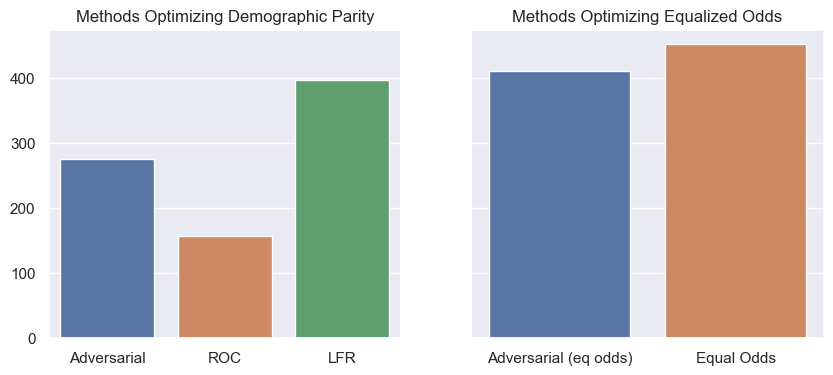

In [52]:
fig, axs = plt.subplots(1,2, figsize=(10,4), sharey=True)

sns.barplot(
    x=['Adversarial', 'ROC', 'LFR'],
    y=[len(t[t.adv_change!=0]), len(t[t.roc_change!=0]),
      len(t[t.lfr_change!=0])],
    ax=axs[0]
           )
axs[0].set_title('Methods Optimizing Demographic Parity')

sns.barplot(
    x = ['Adversarial (eq odds)', 'Equal Odds'],
    y = [len(t[t.adv_eq_change!=0]), len(t[t.eq_change!=0])],
    ax=axs[1]
)
axs[1].set_title('Methods Optimizing Equalized Odds')

In [53]:
tt = t[(t.adv_change!=0) | (t.roc_change!=0) | (t.lfr_change!=0)]
inters_dp = len(tt[(tt.adv_change==tt.roc_change) & (tt.lfr_change==tt.roc_change) & (tt.lfr_change==tt.adv_change)])
union_dp = len(tt)
iou_dp = inters_dp/union_dp * 100

print('Demographic parity methods:')
print(f'IOU(changed instances) = {iou_dp:.2f}%')

tt = t[(t.adv_eq_change!=0) | (t.eq_change!=0)]
inters_eo = len(tt[(tt.adv_eq_change==tt.eq_change)])
union_eo = len(tt)
iou_eo = inters_eo/union_eo * 100

print('Equalized Odds methods:')
print(f'IOU(changed instances) = {iou_eo:.2f}%')

tt = t[(t.adv_change!=0) | (t.roc_change!=0) | (t.lfr_change!=0) | (t.adv_eq_change!=0) | (t.eq_change!=0)]
inters = len(tt[
    (tt.adv_change==tt.roc_change) & (tt.lfr_change==tt.roc_change) & (tt.lfr_change==tt.adv_change) &
    (tt.adv_eq_change==tt.eq_change) &
    (tt.adv_change==tt.adv_eq_change) & (tt.lfr_change==tt.adv_eq_change) & (tt.roc_change==tt.adv_eq_change) &
    (tt.adv_change==tt.eq_change) & (tt.lfr_change==tt.eq_change) & (tt.roc_change==tt.eq_change) 
])
union = len(tt)
iou = inters/union

print('All methods:')
print(f'IOU(changed instances) = {iou:.2f}%')

Demographic parity methods:
IOU(changed instances) = 18.40%
Equalized Odds methods:
IOU(changed instances) = 22.82%
All methods:
IOU(changed instances) = 0.00%


In [54]:
tt[
    #(tt.adv_change==tt.roc_change) & (tt.lfr_change==tt.roc_change) & (tt.lfr_change==tt.adv_change) &
    (tt.adv_eq_change==tt.eq_change) #&
    #(tt.adv_change==tt.adv_eq_change)# & (tt.lfr_change==tt.adv_eq_change)# & (tt.roc_change==tt.adv_eq_change) #&
    #(tt.adv_change==tt.eq_change) & (tt.lfr_change==tt.eq_change) & (tt.roc_change==tt.eq_change) 
]

,age_cat,biased_pred,target,lfr_pred,adv_pred,roc_pred,adv_eq_pred,eq_pred,lfr_change,adv_change,roc_change,adv_eq_change,eq_change
27817,1,1.0,1,0,0.0,1.0,1,1,-1.0,-1.0,0.0,0.0,0.0
29121,0,0.0,0,1,0.0,0.0,0,0,1.0,0.0,0.0,0.0,0.0
28210,0,0.0,0,0,0.0,0.0,1,1,0.0,0.0,0.0,1.0,1.0
39091,0,1.0,1,0,0.0,1.0,0,0,-1.0,-1.0,0.0,-1.0,-1.0
34648,1,1.0,1,1,1.0,0.0,1,1,0.0,0.0,-1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
31509,0,0.0,1,1,0.0,0.0,0,0,1.0,0.0,0.0,0.0,0.0
2064,0,0.0,1,0,0.0,0.0,1,1,0.0,0.0,0.0,1.0,1.0
35010,1,1.0,0,1,1.0,0.0,1,1,0.0,0.0,-1.0,0.0,0.0
28817,0,1.0,0,0,0.0,1.0,1,1,-1.0,-1.0,0.0,0.0,0.0


In [55]:
print('LFR:')
print(f'disadv group in positive class: {len(t[(t.age_cat==0) & (t.lfr_pred==1)]) / len(t[t.age_cat==0]) * 100:.2f}%')
print(f'priv group in positive class: {len(t[(t.age_cat==1) & (t.lfr_pred==1)]) / len(t[t.age_cat==1]) * 100:.2f}%')
print()

print('Adversarial (DP):')
print(f'disadv group in positive class: {len(t[(t.age_cat==0) & (t.adv_pred==1)]) / len(t[t.age_cat==0]) * 100:.2f}%')
print(f'priv group in positive class: {len(t[(t.age_cat==1) & (t.adv_pred==1)]) / len(t[t.age_cat==1]) * 100:.2f}%')
print()

print('ROC:')
print(f'disadv group in positive class: {len(t[(t.age_cat==0) & (t.roc_pred==1)]) / len(t[t.age_cat==0]) * 100:.2f}%')
print(f'priv group in positive class: {len(t[(t.age_cat==1) & (t.roc_pred==1)]) / len(t[t.age_cat==1]) * 100:.2f}%')
print()

print('Adversarial (EO):')
print(f'disadv group in positive class: {len(t[(t.age_cat==0) & (t.adv_eq_pred==1)]) / len(t[t.age_cat==0]) * 100:.2f}%')
print(f'priv group in positive class: {len(t[(t.age_cat==1) & (t.adv_eq_pred==1)]) / len(t[t.age_cat==1]) * 100:.2f}%')
print()

print('Equal Odds:')
print(f'disadv group in positive class: {len(t[(t.age_cat==0) & (t.eq_pred==1)]) / len(t[t.age_cat==0]) * 100:.2f}%')
print(f'priv group in positive class: {len(t[(t.age_cat==1) & (t.eq_pred==1)]) / len(t[t.age_cat==1]) * 100:.2f}%')
print()

print('Biased:')
print(f'disadv group in positive class: {len(t[(t.age_cat==0) & (t.biased_pred==1)]) / len(t[t.age_cat==0]) * 100:.2f}%')
print(f'priv group in positive class: {len(t[(t.age_cat==1) & (t.biased_pred==1)]) / len(t[t.age_cat==1]) * 100:.2f}%')
print()


LFR:
disadv group in positive class: 7.86%
priv group in positive class: 9.32%

Adversarial (DP):
disadv group in positive class: 6.62%
priv group in positive class: 7.77%

ROC:
disadv group in positive class: 6.72%
priv group in positive class: 7.73%

Adversarial (EO):
disadv group in positive class: 9.60%
priv group in positive class: 14.63%

Equal Odds:
disadv group in positive class: 14.05%
priv group in positive class: 22.65%

Biased:
disadv group in positive class: 6.72%
priv group in positive class: 15.26%



In [56]:
t_fts = df.loc[t.index].join(t)

adv_changed = t_fts[t_fts.adv_change!=0]
eq_changed = t_fts[t_fts.eq_change!=0]
roc_changed = t_fts[t_fts.roc_change!=0]

adv_changed.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,lfr_pred,adv_pred,roc_pred,adv_eq_pred,eq_pred,lfr_change,adv_change,roc_change,adv_eq_change,eq_change
27817,88,retired,divorced,basic.4y,no,no,no,cellular,mar,wed,...,0,0.0,1.0,1,1,-1.0,-1.0,0.0,0.0,0.0
39091,41,admin.,married,university.degree,no,no,no,cellular,dec,thu,...,0,0.0,1.0,0,0,-1.0,-1.0,0.0,-1.0,-1.0
32351,33,blue-collar,married,basic.9y,no,yes,no,cellular,may,fri,...,1,0.0,0.0,0,1,0.0,-1.0,-1.0,-1.0,0.0
37027,26,services,single,high.school,no,no,no,cellular,jul,tue,...,0,0.0,0.0,0,1,-1.0,-1.0,-1.0,-1.0,0.0
38960,76,retired,married,university.degree,no,yes,no,cellular,dec,wed,...,0,0.0,1.0,0,1,-1.0,-1.0,0.0,-1.0,0.0


In [57]:
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'],
      dtype='object')

In [58]:
adv_changed.describe()[['age', 'duration', 'campaign', 'pdays',
       'previous', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed']]

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,275.000000,275.000000,275.000000,275.000000,275.000000,275.000000,275.000000,275.000000,275.000000,275.000000
mean,40.192727,579.425455,1.869091,796.749091,0.458182,-1.182545,93.328767,-39.927636,2.180909,5100.511636
std,15.423793,494.802369,1.546467,400.693740,0.797508,1.628954,0.666606,6.319565,1.757257,84.332124
min,18.000000,19.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.635000,4963.600000
25%,29.000000,249.000000,1.000000,999.000000,0.000000,-1.800000,92.893000,-46.200000,0.856500,5017.500000
50%,34.000000,435.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-40.300000,1.313000,5099.100000
75%,49.000000,755.000000,2.000000,999.000000,1.000000,1.100000,93.918000,-36.100000,4.856500,5191.000000
max,88.000000,4199.000000,13.000000,999.000000,5.000000,1.400000,94.767000,-26.900000,4.968000,5228.100000


In [59]:
adv_changed.groupby('marital').count().sort_values(by='age', ascending=False)[['age']].head()

,age
marital,
married,131
single,114
divorced,28
unknown,2


In [60]:
eq_changed.groupby('marital').count().sort_values(by='age', ascending=False)[['age']].head()

,age
marital,
married,253
single,142
divorced,55
unknown,1


In [61]:
roc_changed.groupby('marital').count().sort_values(by='age', ascending=False)[['age']].head()

,age
marital,
single,92
married,52
divorced,12


In [62]:
adv_changed.groupby('job').count().sort_values(by='age', ascending=False)[['age']].head()

,age
job,
admin.,91
blue-collar,36
technician,32
retired,30
student,27


In [63]:
eq_changed.groupby('job').count().sort_values(by='age', ascending=False)[['age']].head()

,age
job,
admin.,139
technician,71
blue-collar,61
management,43
services,33


In [64]:
roc_changed.groupby('job').count().sort_values(by='age', ascending=False)[['age']].head()

,age
job,
admin.,58
student,22
blue-collar,21
retired,18
technician,14


In [65]:
roc_changed.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,...,lfr_pred,adv_pred,roc_pred,adv_eq_pred,eq_pred,lfr_change,adv_change,roc_change,adv_eq_change,eq_change
count,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,...,156.000000,156.000000,156.0,156.000000,156.0,156.000000,156.000000,156.0,156.000000,156.0
mean,35.217949,619.833333,2.057692,795.384615,0.346154,-1.097436,93.399942,-40.272436,2.223244,5099.456410,...,0.320513,0.307692,0.0,0.564103,1.0,-0.679487,-0.692308,-1.0,-0.435897,0.0
std,16.200874,472.662463,1.693404,402.111082,0.639091,1.672971,0.688981,6.372214,1.798075,87.518825,...,0.468177,0.463025,0.0,0.497471,0.0,0.468177,0.463025,0.0,0.497471,0.0
min,18.000000,68.000000,1.000000,1.000000,0.000000,-3.400000,92.201000,-50.800000,0.635000,4963.600000,...,0.000000,0.000000,0.0,0.000000,1.0,-1.000000,-1.000000,-1.0,-1.000000,0.0
25%,27.750000,256.750000,1.000000,999.000000,0.000000,-1.800000,92.893000,-46.200000,0.860500,5017.500000,...,0.000000,0.000000,0.0,0.000000,1.0,-1.000000,-1.000000,-1.0,-1.000000,0.0
50%,30.000000,502.500000,1.000000,999.000000,0.000000,-1.800000,93.369000,-40.300000,1.290000,5099.100000,...,0.000000,0.000000,0.0,1.000000,1.0,-1.000000,-1.000000,-1.0,0.000000,0.0
75%,33.000000,770.250000,2.000000,999.000000,1.000000,1.100000,93.994000,-36.100000,4.858250,5191.000000,...,1.000000,1.000000,0.0,1.000000,1.0,0.000000,0.000000,-1.0,0.000000,0.0
max,88.000000,2692.000000,11.000000,999.000000,3.000000,1.400000,94.767000,-26.900000,4.968000,5228.100000,...,1.000000,1.000000,0.0,1.000000,1.0,0.000000,0.000000,-1.0,0.000000,0.0


In [67]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
17970,37,admin.,single,high.school,no,yes,no,cellular,jul,tue,...,5,999,0,nonexistent,1.4,93.918,-42.7,4.961,5228.1,no
27908,36,management,married,university.degree,no,yes,no,cellular,mar,thu,...,2,999,0,nonexistent,-1.8,92.843,-50.0,1.538,5099.1,no
36682,51,technician,single,university.degree,no,no,no,cellular,jun,fri,...,1,999,0,nonexistent,-2.9,92.963,-40.8,1.268,5076.2,yes
36344,59,retired,divorced,university.degree,no,no,no,cellular,jun,tue,...,2,999,0,nonexistent,-2.9,92.963,-40.8,1.262,5076.2,no
3723,50,technician,married,professional.course,no,no,no,telephone,may,fri,...,2,999,0,nonexistent,1.1,93.994,-36.4,4.859,5191.0,no


In [68]:
test_results.head()

,age_cat,biased_pred,lfr_pred,lfr_change,adv_pred,adv_eq_pred,adv_eq_change,eq_pred,eq_change,roc_pred,roc_change
26792,1,0.0,0,0.0,0.0,0,0.0,0,0.0,0.0,0.0
26127,1,0.0,0,0.0,0.0,0,0.0,0,0.0,0.0,0.0
30552,0,0.0,0,0.0,0.0,0,0.0,0,0.0,0.0,0.0
14952,1,0.0,0,0.0,0.0,0,0.0,0,0.0,0.0,0.0
27817,1,1.0,0,-1.0,0.0,1,0.0,1,0.0,1.0,0.0


# T-sne and PCA

In [70]:
t.head()

,age_cat,biased_pred,target,lfr_pred,adv_pred,roc_pred,adv_eq_pred,eq_pred,lfr_change,adv_change,roc_change,adv_eq_change,eq_change
26792,1,0.0,0,0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0
26127,1,0.0,0,0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0
30552,0,0.0,0,0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0
14952,1,0.0,0,0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0
27817,1,1.0,1,0,0.0,1.0,1,1,-1.0,-1.0,0.0,0.0,0.0


In [71]:
a_df = t[t.adv_change!=0]
l_df = t[t.lfr_change!=0]
e_df = t[t.eq_change!=0]
r_df = t[t.roc_change!=0]
ae_df = t[t.adv_eq_change!=0]

In [72]:
tsne_tr = pd.concat([X_train.assign(z = Z_train), X_test.assign(z = Z_test)])

In [73]:
from sklearn.manifold import TSNE

tsne_df = TSNE(n_components=2, learning_rate='auto',
                   init='random', perplexity=25).fit_transform(tsne_tr)


In [75]:
import matplotlib.patches as mpatches

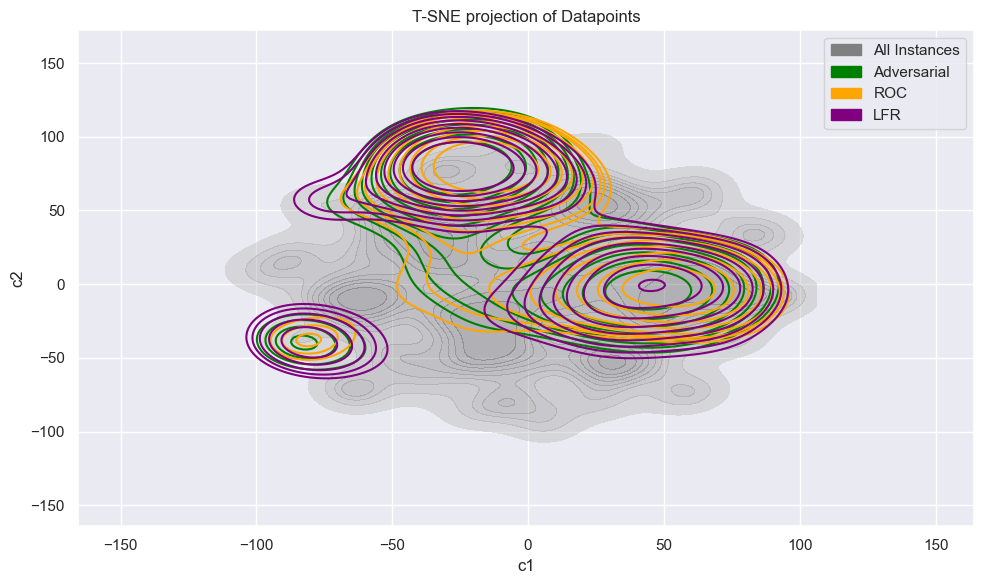

In [76]:
all_df = tsne_tr.assign(c1 = tsne_df[:,0],
             c2 = tsne_df[:,1])

plot_a = all_df.loc[a_df.index]
plot_r = all_df.loc[r_df.index]
plot_e = all_df.loc[e_df.index]
plot_l = all_df.loc[l_df.index]
plot_x = all_df#.loc[same_df.index]

fig, axs = plt.subplots(1,1, figsize=(10,6))#, sharex=True, sharey=True)

sns.kdeplot(data=plot_x, x='c1', y='c2', ax=axs, label='All Instances', fill=True, 
            thresh=0.05, alpha=0.4, legend=True, color='Grey', cut=0.5)

patch_all = mpatches.Patch(
    color='Grey', label='All Instances'
)

#sns.kdeplot(data=plot_e, x='c1', y='c2', ax=axs, label='Equal Odds', fill=False, thresh=0.4, color='Blue')#, cut=0.3)
#patch_eq = mpatches.Patch(
#    color='Blue', label='Equal Odds'
#)

sns.kdeplot(data=plot_a, x='c1', y='c2', ax=axs, label='Adversarial', fill=False, thresh=0.4, color='Green')#, cut=0.3)
patch_adv = mpatches.Patch(
    color='Green', label='Adversarial'
)

sns.kdeplot(data=plot_r, x='c1', y='c2', ax=axs, label='ROC', fill=False, thresh=0.4, color='Orange')#, cut=0.3)
patch_roc = mpatches.Patch(
    color='Orange', label='ROC'
)

sns.kdeplot(data=plot_l, x='c1', y='c2', ax=axs, label='LFR', fill=False, thresh=0.4, color='Purple')
patch_lfr = mpatches.Patch(
    color='Purple', label='LFR'
)

label_patches = [patch_all, patch_adv, patch_roc, patch_lfr]


axs.legend(handles=label_patches)

axs.set_title('T-SNE projection of Datapoints')

#plt.xlim((-60,60))
#plt.ylim((-60,60))

#plt.savefig('../../figs/compas/tsne_all.pdf')
#plt.savefig('../../figs/compas/tsne_all.png')
plt.tight_layout()

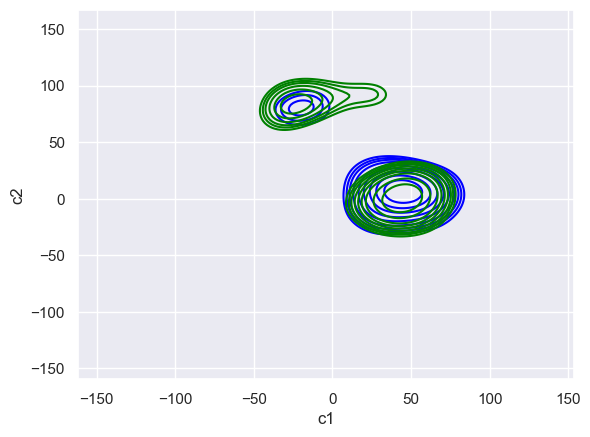

In [77]:
fig, axs = plt.subplots(1,1)


sns.kdeplot(data=plot_e, x='c1', y='c2', ax=axs, label='Equal Odds', fill=False, thresh=0.7, color='Blue')#, cut=0.3)
patch_eq = mpatches.Patch(
    color='Blue', label='Equal Odds'
)

sns.kdeplot(data=plot_ae, x='c1', y='c2', ax=axs, label='Adversarial', fill=False, thresh=0.7, color='Green')#, cut=0.3)
patch_adv = mpatches.Patch(
    color='Green', label='Adversarial'
)

#sns.kdeplot(data=plot_r, x='c1', y='c2', ax=axs, label='ROC', fill=False, thresh=0.7, color='Orange')#, cut=0.3)
#patch_lfr = mpatches.Patch(
#    color='Orange', label='ROC'
#)

#plt.xlim(-10, 85)
#plt.ylim(-25, 40)

In [78]:
pd.concat([plot_e.assign(method='Equal Odds') , plot_l.assign(method='LFR'), plot_a.assign(method='Adversarial')])

,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,job_blue-collar,...,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_nonexistent,poutcome_success,z,c1,c2,method
15643,0.855025,2.961994,0.190913,-0.343545,0.845600,0.594808,-0.481061,0.776491,0.848728,-0.527731,...,1.947391,-0.522048,-0.487729,-0.48406,0.392232,-0.180838,0,-34.782433,-20.132948,Equal Odds
28210,0.062287,-0.557137,0.190913,-0.343545,-1.192886,-0.872020,-1.434838,-1.242800,-0.920393,-0.527731,...,-0.513508,-0.522048,2.050321,-0.48406,0.392232,-0.180838,0,50.117611,23.874893,Equal Odds
39091,-0.174757,-0.557137,0.190913,-0.343545,-1.957319,-1.501904,1.621584,-1.672339,-1.957181,-0.527731,...,-0.513508,1.915531,-0.487729,-0.48406,0.392232,-0.180838,0,-32.228367,105.791840,Equal Odds
2276,1.018236,-0.557137,0.190913,-0.343545,0.654492,0.727049,0.884574,0.716609,0.339934,-0.527731,...,-0.513508,-0.522048,2.050321,-0.48406,0.392232,-0.180838,0,-23.523359,41.924683,Equal Odds
8308,0.687928,0.146689,0.190913,-0.343545,0.845600,1.546594,-0.285971,0.721215,0.848728,-0.527731,...,-0.513508,-0.522048,2.050321,-0.48406,0.392232,-0.180838,0,-39.998367,-3.682022,Equal Odds
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9732,1.787658,0.146689,0.190913,-0.343545,0.845600,1.546594,-0.285971,0.777067,0.848728,-0.527731,...,1.947391,-0.522048,-0.487729,-0.48406,0.392232,-0.180838,1,-51.381355,1.267334,Adversarial
28817,1.593360,0.146689,0.190913,1.649948,-1.192886,-0.872020,-1.434838,-1.267559,-0.920393,1.894905,...,-0.513508,1.915531,-0.487729,-0.48406,-2.549510,-0.180838,0,44.182167,-18.793787,Adversarial
9052,2.926248,-0.205224,0.190913,-0.343545,0.845600,1.546594,-0.285971,0.722367,0.848728,-0.527731,...,-0.513508,1.915531,-0.487729,-0.48406,0.392232,-0.180838,0,-57.872242,-19.824177,Adversarial
40174,-0.287450,-0.557137,-5.222240,5.636936,-1.129184,1.111591,0.039181,-1.583667,-2.394661,-0.527731,...,-0.513508,-0.522048,-0.487729,-0.48406,-2.549510,-0.180838,1,33.069595,-20.103298,Adversarial


# Done until here (after is old code / stuff that's not done)

## Umap

In [79]:
import umap

In [80]:
reducer = umap.UMAP()

AttributeError: module 'umap' has no attribute 'UMAP'

In [ ]:
embedding = reducer.fit_transform(X_test)

In [ ]:
umap_df = pd.DataFrame(embedding, columns=['c1', 'c2'], index=X_test.index)
umap_df.head()

In [ ]:
sns.kdeplot(data=umap_df, x='c1', y='c2')#, kind='hex')

In [ ]:
all_df = umap_df#X_test.assign(c1 = umap_df[:,0],
             #c2 = umap_df[:,1])

plot_a = all_df.loc[a_df.index]
plot_l = all_df.loc[l_df.index]
plot_e = all_df.loc[e_df.index]
plot_x = all_df#.loc[same_df.index]

fig, axs = plt.subplots(1,1, figsize=(10,6))#, sharex=True, sharey=True)

sns.kdeplot(data=plot_x, x='c1', y='c2', ax=axs, label='All Instances', fill=True, 
            thresh=0.1, alpha=0.4, legend=True, color='Grey', cut=0.5)

patch_all = mpatches.Patch(
    color='Grey', label='All Instances'
)

sns.kdeplot(data=plot_e, x='c1', y='c2', ax=axs, label='Equal Odds', fill=False, thresh=0.6, color='Blue')#, cut=0.3)
patch_eq = mpatches.Patch(
    color='Blue', label='Equal Odds'
)

sns.kdeplot(data=plot_a, x='c1', y='c2', ax=axs, label='Adversarial', fill=False, thresh=0.6, color='Green')#, cut=0.3)
patch_adv = mpatches.Patch(
    color='Green', label='Adversarial'
)

sns.kdeplot(data=plot_l, x='c1', y='c2', ax=axs, label='LFR', fill=False, thresh=0.6, color='Orange')#, cut=0.3)
patch_lfr = mpatches.Patch(
    color='Orange', label='LFR'
)

label_patches = [patch_all, patch_eq, patch_adv, patch_lfr]


axs.legend(handles=label_patches)

axs.set_title('Umap projection of Datapoints')

plt.xlim((-30,40))
plt.ylim((-30,40))

plt.tight_layout()

In [ ]:
import umap

In [ ]:
reducer = umap.UMAP()

In [ ]:
embedding = reducer.fit_transform(changed)

In [ ]:
umap_df = pd.DataFrame(embedding, columns=['c1', 'c2'], index=changed.index)
umap_df.head()

In [ ]:
sns.kdeplot(data=umap_df, x='c1', y='c2')#, kind='hex')

In [ ]:
all_df = umap_df#X_test.assign(c1 = umap_df[:,0],
             #c2 = umap_df[:,1])

plot_a = all_df.loc[a_df.index]
plot_l = all_df.loc[l_df.index]
plot_e = all_df.loc[e_df.index]
plot_x = all_df#.loc[same_df.index]

fig, axs = plt.subplots(1,1, figsize=(10,6))#, sharex=True, sharey=True)

sns.kdeplot(data=plot_x, x='c1', y='c2', ax=axs, label='All Instances', fill=True, 
            thresh=0.1, alpha=0.4, legend=True, color='Grey', cut=0.5)

patch_all = mpatches.Patch(
    color='Grey', label='All Instances'
)

sns.kdeplot(data=plot_l, x='c1', y='c2', ax=axs, label='LFR', fill=False, thresh=0.6, color='Orange')#, cut=0.3)
patch_lfr = mpatches.Patch(
    color='Orange', label='LFR'
)

sns.kdeplot(data=plot_e, x='c1', y='c2', ax=axs, label='Equal Odds', fill=False, thresh=0.6, color='Blue')#, cut=0.3)
patch_eq = mpatches.Patch(
    color='Blue', label='Equal Odds'
)

sns.kdeplot(data=plot_a, x='c1', y='c2', ax=axs, label='Adversarial', fill=False, thresh=0.6, color='Green')#, cut=0.3)
patch_adv = mpatches.Patch(
    color='Green', label='Adversarial'
)

label_patches = [patch_all, patch_eq, patch_adv, patch_lfr]


axs.legend(handles=label_patches)

axs.set_title('Umap projection of Datapoints')

plt.xlim((-30,40))
plt.ylim((-20,35))

plt.tight_layout()

# DIG + Decision Tree

In [ ]:
import discrepancies as disc
from discrepancies import pool
from discrepancies import DIG

In [ ]:
class LFR_model:
    
    def __init__(self, lfr, model):
        self.lfr = lfr
        self.model = model
    
    def fit(self):
        pass
    
    def predict(self, XZ):
        bld = BinaryLabelDataset(df=XZ.assign(score_factor=0),
                                label_names=['score_factor'],
                                protected_attribute_names=['race'])
        return self.model.predict(self.lfr.transform(bld)).labels
    
class EQ_model:
    
    def __init__(self, model):
        self.model = model
    
    def fit(self):
        pass
    
    def predict(self, XZ):
        
        bld = BinaryLabelDataset(df=XZ.assign(score_factor=0),
                                label_names=['score_factor'],
                                protected_attribute_names=['race'])
        
        X = XZ.drop(columns = ['race'])
        y = pd.Series(np.zeros(len(X)), name='score_factor')
        Z = XZ['race']
        
        return self.model.predict(
            X=X, y=y, Z=Z, sensitive_features=Z,
            bld=bld
        )
    
class Adversarial_model:
    
    def __init__(self, model):
        self.model = model
        
    def fit(self):
        pass
    
    def predict(self, XZ):
        
        bld = BinaryLabelDataset(df=XZ.assign(score_factor=0),
                                label_names=['score_factor'],
                                protected_attribute_names=['race'])
        
        return self.model.predict(bld).labels

In [ ]:
lfr_wrap = LFR_model(lfr, model)
eq_wrap = EQ_model(m)
adv_wrap = Adversarial_model(debiased_model)
biased_wrap = Adversarial_model(biased_model)

#fpool = pool.FairnessPool([lfr_wrap, eq_wrap, adv_wrap, biased_wrap], 
#                          ['LFR', 'Equal Odds', 'Adversarial', 'Biased'],
#                         'race')

eq_pool = pool.FairnessPool([eq_wrap, biased_wrap], ['Equal Odds', 'Biased'], 'race')
adv_pool = pool.FairnessPool([adv_wrap, biased_wrap], ['Adversarial', 'Biased'], 'race')
lfr_pool = pool.FairnessPool([lfr_wrap, biased_wrap], ['LFR', 'Biased'], 'race')

In [ ]:
adv_pool.predict(XZ=X_test.join(y_test).join(Z_test))

In [ ]:
sample = X_test.join(Z_test).join(y_test).sample(100).assign(score_factor=0)
bld_sample = BinaryLabelDataset(
    df=sample,
    label_names=['score_factor'],
    protected_attribute_names=['race']
)

In [ ]:
sample.head()

In [ ]:
adv_pool.predict_discrepancies(sample)

In [ ]:
eq_digger = DIG.Digger(
    sample.drop(columns=['score_factor']),
    sample.score_factor,
    eq_pool,
    categorical_names=['sex', 'felony']
).fit(max_epochs=7)

In [ ]:
adv_digger = DIG.Digger(
    sample.drop(columns=['score_factor']),
    sample.score_factor,
    adv_pool,
    categorical_names=['sex', 'felony']
).fit(max_epochs=7)

In [ ]:
nodes = pd.concat([adv_digger.get_nodes_attributes(adv_digger.get_nodes())[0],
           adv_digger.get_nodes_attributes(adv_digger.get_nodes())[1]],
         axis=1).assign(discrepancy = lambda x: (x['Adversarial']!=x['Biased']).astype(int))

nodes.head()#[nodes.isna().any(axis=1)]

In [ ]:
(trainx, testx, trainy, testy,
     trainz, testz) = train_test_split(X, y, Z, test_size=0.5,
                                         stratify=y, random_state=11)

scaler = StandardScaler().fit(trainx)

nodes_unscaled = pd.DataFrame(scaler.inverse_transform(nodes[X_test.columns]), columns=X_test.columns,
            index=nodes.index)
nodes_unscaled.head()

In [ ]:
dff = pd.concat([
    nodes_unscaled,
    nodes[['race', 'Adversarial', 'Biased']]
], axis=1).assign(discrepancy = lambda x: (x['Adversarial']!=x['Biased']).astype(int))\
  .drop(columns=['Adversarial', 'Biased'])\
  .assign(race = lambda x: (x.race>0.5).astype(int))
dff.head()

In [ ]:
testx.describe()

In [ ]:
dff.describe()

In [ ]:
sc_dfff = nodes.assign(discrepancy = lambda x: (x['Adversarial']!=x['Biased']).astype(int)).drop(columns=['Adversarial', 'Biased', 'race'])

In [ ]:
#x_tree_train, x_tree_test, y_tree_train, y_tree_test = train_test_split(dff.drop(columns=['discrepancy']),
#                                                                       dff[['discrepancy']],
#                                                                       test_size=0.5, stratify=dff[['discrepancy']], random_state=11)

#x_tree_train, x_tree_test, y_tree_train, y_tree_test = train_test_split(sc_dfff.drop(columns=['discrepancy']),
#                                                                       sc_dfff[['discrepancy']],
#                                                                       test_size=0.5, stratify=sc_dfff[['discrepancy']], random_state=11)

In [ ]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(max_depth=10)
clf = clf.fit(x_tree_train.to_numpy(), y_tree_train)

In [ ]:
preds = clf.predict(x_tree_test)

metrics.balanced_accuracy_score(y_tree_test, preds)

In [ ]:
from sklearn import tree

fig, axs = plt.subplots(1,1,figsize=(18,10))

tree.plot_tree(clf)

plt.show()

In [ ]:
list(X_test.columns)+['race']

In [ ]:
dff.race.unique()

In [ ]:
import graphviz

In [ ]:
dot_data = tree.export_graphviz(clf, out_file=None, feature_names=list(X_test.columns), class_names=['not changed', 'changed'])
graph = graphviz.Source(dot_data)
#graph.render('adult'),

In [ ]:
graph.render('compas_adv')

In [ ]:
leaves = clf.apply(x_tree_test)

In [ ]:
tree_df = pd.DataFrame(scaler.inverse_transform(x_tree_test), columns=x_tree_test.columns, index=x_tree_test.index)\
            .assign(leaf=leaves).assign(discrepancy=y_tree_test)
tree_df.head()

In [ ]:
tree_df.groupby(['leaf', 'discrepancy']).count().reset_index().sort_values(['discrepancy', 'sex'], ascending=False)[0:10] #.sort_values('sex')

In [ ]:
x_tree_test.shape

In [ ]:
tree_df[tree_df.leaf==315].describe().drop(columns=['leaf', 'discrepancy']).loc[['min', 'max']].rename({'sex':'Gender',
                                                                                                       'age':'Age',
                                                                                                       'priors_count':'Priors',
                                                                                                       'juv_fel_count':'Juvenial Felonies',
                                                                                                       'juv_misd_count':'Juvenial Misdemeanors',
                                                                                                       'felony':'Felony'}, axis=1)

In [ ]:
tree_df[tree_df.leaf==263].describe().drop(columns=['leaf', 'discrepancy']).loc[['min', 'max']].rename({'sex':'Gender',
                                                                                                       'age':'Age',
                                                                                                       'priors_count':'Priors',
                                                                                                       'juv_fel_count':'Juvenial Felonies',
                                                                                                       'juv_misd_count':'Juvenial Misdemeanors',
                                                                                                       'felony':'Felony'}, axis=1)

In [ ]:
tree_df.head()

In [ ]:
t.groupby(['race', 'eq_change']).count()

In [ ]:
x_tree_train.head()

In [ ]:
nodes.assign()

In [ ]:
t.head()

In [ ]:
t.head()

In [ ]:
plot_df = dd.loc[t.index].assign(
    eq_change = t.eq_change,
    adv_change = t.adv_change,
    lfr_change = t.lfr_change
)

In [ ]:
plot_df[plot_df.eq_change!=0].describe()[['age', 'priors_count', 'juv_fel_count', 'juv_misd_count']]

In [ ]:
plot_df[plot_df.eq_change!=0].groupby('race').count()[['sex']].rename({'sex':'count'}).assign(method='Equal Odds').reset_index()

In [ ]:
plot_df[plot_df.lfr_change!=0].groupby('race').count()[['sex']].rename({'sex':'count'})

In [ ]:
plot_df[plot_df.adv_change!=0].groupby('race').count()[['sex']].rename({'sex':'count'})

In [ ]:
plot_df[plot_df.lfr_change!=0].describe()[['age', 'priors_count', 'juv_fel_count', 'juv_misd_count']]

In [ ]:
testx.head()

In [ ]:
from sklearn.cluster import AgglomerativeClustering

In [ ]:
clusters = AgglomerativeClustering(n_clusters=10).fit_predict(nodes[nodes.discrepancy==1].drop(columns=['discrepancy', 'Adversarial', 'Biased']))

In [ ]:
agl_clusters = nodes[nodes.discrepancy==1].assign(cluster=clusters)
agl_clusters.head()

In [ ]:
from sklearn.cluster import AffinityPropagation

AffinityPropagation().fit_predict(trainx[trainx.discrepancy==1].drop(columns=['discrepancy', 'Adversarial', 'Biased']))

In [ ]:
from sklearn.manifold import TSNE

tsne_df = TSNE(n_components=2, learning_rate='auto',
                   init='random', perplexity=50).fit_transform(agl_clusters.drop(columns=['discrepancy', 'Adversarial', 'Biased', 'cluster']))


In [ ]:
all_df = agl_clusters.assign(c1 = tsne_df[:,0],
             c2 = tsne_df[:,1])

all_df.head()

In [ ]:
fig, axs = plt.subplots(1,1,figsize=(14,7))

sns.scatterplot(data=all_df, x='c1', y='c2', hue='cluster', palette='colorblind')

In [ ]:
fig, axs = plt.subplots(1,1,figsize=(14,7))

sns.scatterplot(data=all_df, x='c1', y='c2', palette='colorblind')

In [ ]:
all_df[all_df.cluster==1].describe()[['age', '']]

In [ ]:
len(all_df)

In [ ]:
sns.kdeplot(data=all_df, x='c1', y='c2', thresh = 0.6)

In [ ]:
all_df = changed.assign(c1 = tsne_df[:,0],
             c2 = tsne_df[:,1])

fig, axs = plt.subplots(1,1, figsize=(18,6))#, sharex=True, sharey=True)

sns.kdeplot(data=all_df, x='c1', y='c2', ax=axs, label='All Instances', fill=False, thresh=0.3)
sns.kdeplot(data=plot_e, x='c1', y='c2', ax=axs[1] , label='Equal Odds', fill=False, thresh=0.3)
sns.kdeplot(data=plot_a, x='c1', y='c2', ax=axs[1] , label='Adversarial', fill=False, alpha=0.6, thresh=0.3)
sns.kdeplot(data=plot_l, x='c1', y='c2', ax=axs[1] , label='LFR', fill=False, alpha=0.4, thresh=0.3)

plt.tight_layout()

# Decision Tree 2.0

In [ ]:
t.head()

In [ ]:
y_tree = (t.biased_pred!=t.adv_pred).astype(int)

In [ ]:
(X_train_og, X_test_og, _, _,
     _, _) = train_test_split(X, y, Z, test_size=0.5,
                                         stratify=y, random_state=11)

og_scaler = StandardScaler().fit(X_train_og)

In [ ]:
check = pd.concat([pd.DataFrame(og_scaler.inverse_transform(X_test), index=X_test.index, columns=X_test.columns), 
           X_test_og], axis=1)
check[check.sex!=check.sex_og]

In [ ]:
X_test_og.columns = X_test_og.columns.map(lambda x: x+'_og')

In [ ]:
tree_data = X_test.assign(race=Z_test)

scaler = StandardScaler().fit(tree_data)

scale_df = lambda df, scaler: pd.DataFrame(scaler.transform(df), 
                                           columns=df.columns, index=df.index)
tree_data = tree_data.pipe(scale_df, scaler)

In [ ]:
tree_data.head()

In [ ]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(max_depth=6)
clf = clf.fit(tree_data.to_numpy(), y_tree)

In [ ]:
preds = clf.predict(tree_data)

metrics.balanced_accuracy_score(y_tree, preds)

In [ ]:
clusters = clf.apply(tree_data)

In [ ]:
cc = pd.DataFrame(og_scaler.inverse_transform(pd.DataFrame(scaler.inverse_transform(tree_data), 
                                         index=tree_data.index,
                                         columns=tree_data.columns).drop(columns=['race'])),
            index=tree_data.index,
            columns=X_test.columns)
cc = cc.assign(
    priors_count = round(cc.priors_count),
    juv_fel_count = round(cc.juv_fel_count)
)

In [ ]:
cc = cc.assign(segment=clusters, y=y_tree)
cc.head()

In [ ]:
cc.groupby('segment').count()[['age']].sort_values('age', ascending=False).head(5)

In [ ]:
cc[cc.y==1].groupby('segment').count()[['age']].sort_values('age', ascending=False).head(5)

In [ ]:
cc[cc.segment==51].describe()

In [ ]:
cc[cc.segment==22].describe()

# Random stuff

In [ ]:
df = pd.read_csv('../../results/compas/test_results.csv').rename({'Unnamed: 0': 'index'}, axis=1).set_index('index')\
                [['race', 'biased_pred', 'lfr_pred', 'adv_pred', 'eq_pred', 'target']]
df.head()

In [ ]:
comp = dd.loc[df.index].assign(
    biased_pred=df.biased_pred,
    adv_pred = df.adv_pred,
    lfr_pred = df.lfr_pred
)
comp.head()

In [ ]:
data = comp[comp.biased_pred != comp.adv_pred]
data_lfr = comp[comp.biased_pred != comp.lfr_pred]

In [ ]:
import plotly.graph_objects as go

fig = go.Figure(data=
    go.Parcoords(
        line_color='blue',
        dimensions = list([
            dict(range = [data.age.min(), data.age.max()],
                 constraintrange = [1,2], # change this range by dragging the pink line
                 label = 'Age', values = data.age),
            
            dict(range = [0,1],
                 label = 'Race', values = data.race,
                 ticktext = ['Black', 'White']),
            
            dict(range = [0,1],
                 label = 'Sex', values = data.sex,
                 ticktext = ['Female', 'Male']),
            
            dict(range = [data.priors_count.min(), data.priors_count.max() ],
                 label = '# Priors', values = data.priors_count),
            
            dict(range = [data.juv_fel_count.min(), data.juv_fel_count.max()],
                 label='# juv. felonies', values = data.juv_fel_count
            ),
            dict(range = [data.biased_pred.min(), data.biased_pred.max()],
                 label='Biased Prediction', values = data.biased_pred
            )
        ])
    )
)
fig.show()

fig = go.Figure(data=
    go.Parcoords(
        line_color='blue',
        dimensions = list([
            dict(range = [data_lfr.age.min(), data_lfr.age.max()],
                 constraintrange = [1,2], # change this range by dragging the pink line
                 label = 'Age', values = data_lfr.age),
            
            dict(range = [0,1],
                 label = 'Race', values = data_lfr.race,
                 ticktext = ['Black', 'White']),
            
            dict(range = [0,1],
                 label = 'Sex', values = data_lfr.sex,
                 ticktext = ['Female', 'Male']),
            
            dict(range = [data_lfr.priors_count.min(), data_lfr.priors_count.max() ],
                 label = '# Priors', values = data_lfr.priors_count),
            
            dict(range = [0, 1],
                 label='# juv. felonies', values = data_lfr.juv_fel_count
            ),
            dict(range = [data_lfr.biased_pred.min(), data_lfr.biased_pred.max()],
                 label='Biased Prediction', values = data_lfr.biased_pred
            )
        ])
    )
)
fig.show()

In [ ]:
data_lfr.juv_fel_count.max()

In [ ]:
import plotly.graph_objects as go

fig = go.Figure(data=
    go.Parcoords(
        line_color='blue',
        dimensions = list([
            dict(range = [data_lfr.age.min(), data_lfr.age.max()],
                 constraintrange = [1,2], # change this range by dragging the pink line
                 label = 'Age', values = data_lfr.age),
            
            dict(range = [0,1],
                 label = 'Race', values = data_lfr.race,
                 ticktext = ['Black', 'White']),
            
            dict(range = [0,1],
                 label = 'Sex', values = data_lfr.sex,
                 ticktext = ['Female', 'Male']),
            
            dict(range = [data_lfr.priors_count.min(), data_lfr.priors_count.max() ],
                 label = '# Priors', values = data_lfr.priors_count),
            
            dict(range = [data_lfr.juv_fel_count.min(), data_lfr.juv_fel_count.max()],
                 label='# juv. felonies', values = data_lfr.juv_fel_count
            ),
            dict(range = [data_lfr.biased_pred.min(), data_lfr.biased_pred.max()],
                 label='Biased Prediction', values = data_lfr.biased_pred
            )
        ])
    )
)
fig.show()

In [ ]:
data.shape

In [ ]:
data[data.sex==0]